In [201]:
import keras
import pandas as pd
import numpy as np
from keras.layers import *
from keras.activations import *
from keras.callbacks import *
from keras.optimizers import *
from keras.models import *
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
import stldecompose

In [202]:
data_orig = pd.read_csv('../data/files/multiple_concatenated_tickers.csv')
data_orig.tail()

,Index,QQQ.Open,QQQ.High,QQQ.Low,QQQ.Close,QQQ.Volume,QQQ.Adjusted,TSLA.Open,TSLA.High,TSLA.Low,...,T.Low,T.Close,T.Volume,T.Adjusted,V.Open,V.High,V.Low,V.Close,V.Volume,V.Adjusted
3105,2019-05-06,187.050003,190.199997,186.759995,189.940002,38371800,189.940002,250.020004,258.350006,248.500000,...,30.379999,30.590000,25182000,30.590000,158.210007,162.649994,158.199997,162.279999,10442400.0,162.279999
3106,2019-05-07,187.869995,188.669998,184.509995,186.240005,58818100,186.240005,256.799988,257.209991,245.100006,...,30.280001,30.530001,25771200,30.530001,160.949997,161.779999,158.679993,160.210007,6413600.0,160.210007
3107,2019-05-08,185.630005,187.169998,184.960007,185.770004,37165300,185.770004,246.940002,250.600006,244.199997,...,30.170000,30.299999,25015200,30.299999,159.770004,161.699997,159.520004,160.759995,5445900.0,160.759995
3108,2019-05-09,183.699997,185.410004,182.089996,184.770004,55351700,184.770004,242.000000,243.679993,236.940002,...,30.129999,30.379999,27078400,30.379999,158.860001,159.850006,157.169998,159.809998,6813700.0,159.809998
3109,2019-05-10,184.110001,185.889999,181.029999,185.000000,58526400,185.000000,239.750000,241.990005,236.020004,...,30.160000,30.620001,22013300,30.620001,158.860001,161.399994,157.270004,160.710007,5192500.0,160.710007


In [166]:
from urllib.request import *
from io import StringIO
import pandas as pd

def df_from_fred(setname):
    # Make GET Request
    response = urlopen(url_for(setname))
    # Read response data
    data = response.read()
    # Convert binary text to utf-8
    text = data.decode('utf-8')
    # Convert text file to pandas dataframe
    TEXTDATA = StringIO(text)
    df = pd.read_csv(TEXTDATA, sep=",")
    return df

def url_for(series):
    """function takes FRED series name as input. For example, GDPC1, or HOUST."""
    return "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=968&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id="+series+"&scale=left&cosd=1947-01-01&coed=2019-01-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2019-05-07&revision_date=2019-05-07&nd=1947-01-01"


In [156]:
# Vital Economic indicators: https://gist.github.com/ngopal/262fce10a7fa4a8467f0c61a13c85dc5
GDPC1 = df_from_fred("GDPC1")
time.sleep(5)
M2 = df_from_fred("M2")
time.sleep(5)
CPALTT01USQ657N = df_from_fred("CPALTT01USQ657N")
time.sleep(5)
PPIACO = df_from_fred("PPIACO")
time.sleep(5)
UMCSENT = df_from_fred("UMCSENT")
time.sleep(5)
PAYEMS = df_from_fred("PAYEMS")
time.sleep(5)
RRSFS = df_from_fred("RRSFS")
time.sleep(5)
HOUST = df_from_fred("HOUST")
time.sleep(5)
ISRATIO = df_from_fred("ISRATIO")
time.sleep(5)
SP500 = df_from_fred("SP500")
time.sleep(5)

# Others
IPMAN = df_from_fred("IPMAN")
time.sleep(5)
MPU9900063 = df_from_fred("MPU9900063")
time.sleep(5)
PCU33443344 = df_from_fred("PCU33443344")
time.sleep(5)
MEHOINUSA672N = df_from_fred("MEHOINUSA672N")
time.sleep(5)
TCMDO = df_from_fred("TCMDO")
time.sleep(5)
FGTCMDODNS = df_from_fred("FGTCMDODNS")
time.sleep(5)
ADSLFAA027N = df_from_fred("ADSLFAA027N")
time.sleep(5)
NCBCMDPMVCE = df_from_fred("NCBCMDPMVCE")
time.sleep(5)
FGCCSAQ027S = df_from_fred("FGCCSAQ027S")
time.sleep(5)
ASTNITA = df_from_fred("ASTNITA")
time.sleep(5)
PCETRIM12M159SFRBDAL = df_from_fred("PCETRIM12M159SFRBDAL")

# IPMAN, MPU9900063, PCU33443344, MEHOINUSA672N, TCMDO, FGTCMDODNS, ADSLFAA027N, NCBCMDPMVCE, FGCCSAQ027S, ASTNITA

In [167]:
data_orig = data_orig\
  .merge(GDPC1, how="left", left_on=data_orig.Index, right_on=GDPC1.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(M2, how="left", left_on=data_orig.Index, right_on=M2.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(CPALTT01USQ657N, how="left", left_on=data_orig.Index, right_on=CPALTT01USQ657N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PPIACO, how="left", left_on=data_orig.Index, right_on=PPIACO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(UMCSENT, how="left", left_on=data_orig.Index, right_on=UMCSENT.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PAYEMS, how="left", left_on=data_orig.Index, right_on=PAYEMS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(RRSFS, how="left", left_on=data_orig.Index, right_on=RRSFS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(HOUST, how="left", left_on=data_orig.Index, right_on=HOUST.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ISRATIO, how="left", left_on=data_orig.Index, right_on=ISRATIO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PCETRIM12M159SFRBDAL, how="left", left_on=data_orig.Index, right_on=PCETRIM12M159SFRBDAL.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ASTNITA, how="left", left_on=data_orig.Index, right_on=ASTNITA.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FGCCSAQ027S, how="left", left_on=data_orig.Index, right_on=FGCCSAQ027S.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(NCBCMDPMVCE, how="left", left_on=data_orig.Index, right_on=NCBCMDPMVCE.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ADSLFAA027N, how="left", left_on=data_orig.Index, right_on=ADSLFAA027N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FGTCMDODNS, how="left", left_on=data_orig.Index, right_on=FGTCMDODNS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(TCMDO, how="left", left_on=data_orig.Index, right_on=TCMDO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(MEHOINUSA672N, how="left", left_on=data_orig.Index, right_on=MEHOINUSA672N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PCU33443344, how="left", left_on=data_orig.Index, right_on=PCU33443344.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(MPU9900063, how="left", left_on=data_orig.Index, right_on=MPU9900063.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(IPMAN, how="left", left_on=data_orig.Index, right_on=IPMAN.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(SP500, how="left", left_on=data_orig.Index, right_on=SP500.DATE).fillna(method="ffill")\
  .fillna(-1)

In [168]:
data_orig.drop(['DATE_y', 'DATE_x', 'key_0', 'DATE'], axis=1, inplace=True)

In [170]:
list(data_orig.columns)

['Index',
 'XLE.Open',
 'XLE.High',
 'XLE.Low',
 'XLE.Close',
 'XLE.Volume',
 'XLE.Adjusted',
 'XLB.Open',
 'XLB.High',
 'XLB.Low',
 'XLB.Close',
 'XLB.Volume',
 'XLB.Adjusted',
 'XLI.Open',
 'XLI.High',
 'XLI.Low',
 'XLI.Close',
 'XLI.Volume',
 'XLI.Adjusted',
 'XLY.Open',
 'XLY.High',
 'XLY.Low',
 'XLY.Close',
 'XLY.Volume',
 'XLY.Adjusted',
 'XLP.Open',
 'XLP.High',
 'XLP.Low',
 'XLP.Close',
 'XLP.Volume',
 'XLP.Adjusted',
 'XLV.Open',
 'XLV.High',
 'XLV.Low',
 'XLV.Close',
 'XLV.Volume',
 'XLV.Adjusted',
 'XLF.Open',
 'XLF.High',
 'XLF.Low',
 'XLF.Close',
 'XLF.Volume',
 'XLF.Adjusted',
 'XLK.Open',
 'XLK.High',
 'XLK.Low',
 'XLK.Close',
 'XLK.Volume',
 'XLK.Adjusted',
 'XTL.Open',
 'XTL.High',
 'XTL.Low',
 'XTL.Close',
 'XTL.Volume',
 'XTL.Adjusted',
 'XLU.Open',
 'XLU.High',
 'XLU.Low',
 'XLU.Close',
 'XLU.Volume',
 'XLU.Adjusted',
 'XLRE.Open',
 'XLRE.High',
 'XLRE.Low',
 'XLRE.Close',
 'XLRE.Volume',
 'XLRE.Adjusted',
 'GDPC1',
 'M2',
 'CPALTT01USQ657N',
 'PPIACO',
 'UMCSENT',


In [171]:
ticker_lookup = dict([(i[1].split('.')[0], int(i[0])) for i in enumerate(list(data_orig.columns)) if 'Open' in i[1]])
ticker_lookup

{'XLB': 7,
 'XLE': 1,
 'XLF': 37,
 'XLI': 13,
 'XLK': 43,
 'XLP': 25,
 'XLRE': 61,
 'XLU': 55,
 'XLV': 31,
 'XLY': 19,
 'XTL': 49}

In [172]:
CHOSENTICKER = 'QQQ'

In [175]:
days_lookback = 1
theta = 0.05 # This needs to go between pct_change and argmax apply
# pct_df = data_orig.iloc[:,list(ticker_lookup.values())].pct_change(days_lookback).apply(lambda y: y.argmax(), axis=1).fillna("GSPC.Open")
pct_df = data_orig.iloc[:,list(ticker_lookup.values())].pct_change(days_lookback).apply(lambda y: y.argmax(), axis=1).fillna("XLV.Open")

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  after removing the cwd from sys.path.


In [176]:
inv_map = {v+'.Open': k for k, v in dict(enumerate(list(ticker_lookup.keys()))).items()}
pct_df.map(lambda x: inv_map[x])

0        5
1        9
2        7
3        0
4        2
5        4
6        7
7        5
8        1
9        2
10       0
11       3
12       0
13       4
14       2
15       1
16       9
17       4
18       2
19       0
20       2
21       0
22       2
23       9
24       7
25       3
26       0
27       9
28       1
29       2
        ..
3080     0
3081     1
3082     6
3083     1
3084     8
3085     2
3086     0
3087     4
3088     8
3089     8
3090     2
3091     8
3092     5
3093     6
3094     4
3095     2
3096     0
3097     5
3098     7
3099     9
3100     6
3101     0
3102     9
3103    10
3104     3
3105     9
3106     5
3107     0
3108     4
3109     0
Length: 3110, dtype: int64

In [177]:
# De-trend data
data_orig_detrended = signal.detrend(data_orig.iloc[:,1:])

scaler = MinMaxScaler(feature_range=(0, 1))
# data_mat = scaler.fit_transform(data_orig.iloc[:,1:])
data_mat = scaler.fit_transform(data_orig_detrended)

In [178]:
seq_len = 180 # days to use for prediction
data = np.array((data_mat))

In [179]:
sequence_length = seq_len + 1
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])

result = np.array(result)

row = round(0.9 * result.shape[0])
train = result[:int(row), :] # Create training set

In [180]:
# np.random.shuffle(train)
x_train = result[:int(row), :]
y_train = to_categorical(pct_df.map(lambda x: inv_map[x]))[:int(row)]
x_test = result[int(row):, :]
y_test = to_categorical(pct_df.map(lambda x: inv_map[x]))[int(row):]

[x_train, y_train, x_test, y_test]

[array([[[0.90389554, 0.90497316, 0.90606556, ..., 0.98592183,
          0.98558089, 0.98523309],
         [0.90289468, 0.90405911, 0.90523959, ..., 1.        ,
          1.        , 1.        ],
         [0.92175623, 0.92270919, 0.92367526, ..., 0.98024238,
          0.97933002, 0.97839891],
         ...,
         [0.82686532, 0.82721261, 0.8275645 , ..., 0.7918213 ,
          0.7890371 , 0.78619893],
         [0.8797671 , 0.88028202, 0.880804  , ..., 0.86755909,
          0.86516048, 0.86271435],
         [0.89495498, 0.89549314, 0.8960387 , ..., 0.88501263,
          0.88262839, 0.88019656]],
 
        [[0.90289468, 0.90405911, 0.90523959, ..., 1.        ,
          1.        , 1.        ],
         [0.92175623, 0.92270919, 0.92367526, ..., 0.98024238,
          0.97933002, 0.97839891],
         [0.94274806, 0.94354057, 0.94434396, ..., 0.9711683 ,
          0.9695305 , 0.9678589 ],
         ...,
         [0.8797671 , 0.88028202, 0.880804  , ..., 0.86755909,
          0.86516048, 0.

In [191]:
LAYERS = 250
model = Sequential()

model.add(LSTM(
    input_dim=data.shape[1],
    output_dim=LAYERS,
    return_sequences=True))
# model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(
    LAYERS,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=y_train.shape[1]))
model.add(Activation('sigmoid'))

start = time.time()
rmsprop = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=rmsprop)
print('compilation time : ', time.time() - start)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 87), units=250)`
  import sys


compilation time :  0.030280351638793945


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=11)`
  app.launch_new_instance()


In [192]:
MODELNAME = 'multiplemodeltest_withoutTrend5'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('./models/'+MODELNAME+'_best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, epsilon=1e-4, mode='min')

/usr/local/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [193]:
VALIDATIONSIZE = 0.25
EPOCHS = 500
#model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5') 
history = model.fit(
    x_train,
    y_train,
    batch_size=512,
    nb_epoch=EPOCHS,
    validation_split=VALIDATIONSIZE,
    callbacks = [reduce_lr_loss, earlyStopping, mcp_save])

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # Remove the CWD from sys.path while we load stuff.


Train on 1977 samples, validate on 659 samples
Epoch 1/500
1977/1977 [==============================] - 57s 29ms/step - loss: 2.5310 - val_loss: 2.5249
Epoch 2/500
1977/1977 [==============================] - 43s 22ms/step - loss: 2.3262 - val_loss: 2.4521
Epoch 3/500
1977/1977 [==============================] - 41s 21ms/step - loss: 2.2816 - val_loss: 2.3760
Epoch 4/500
1977/1977 [==============================] - 42s 21ms/step - loss: 2.2611 - val_loss: 2.3944
Epoch 5/500
1977/1977 [==============================] - 41s 21ms/step - loss: 2.2592 - val_loss: 2.4666
Epoch 6/500
1977/1977 [==============================] - 40s 20ms/step - loss: 2.2516 - val_loss: 2.4571
Epoch 7/500
1977/1977 [==============================] - 41s 21ms/step - loss: 2.2504 - val_loss: 2.4746
Epoch 8/500
1977/1977 [==============================] - 40s 20ms/step - loss: 2.2422 - val_loss: 2.4651

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 9/500
1977/1977 [==========

In [194]:
best_model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5') 

In [195]:
# 5 refers to days of data. 5 days worth. each 1 row has 36 features
days = 5

In [196]:
from collections import defaultdict
dd = defaultdict(list)
qq = defaultdict(list)
for d in range(days):
    li = []
    for k in sorted(zip(list(ticker_lookup.keys()), best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))[d]), key = lambda x: x[1], reverse=True):
        dd[k[0]].append(k[1])
        li.append(k[0])
    qq[d] = li

In [197]:
dd

defaultdict(list,
            {'XLB': [0.6930003, 0.69118404, 0.6898797, 0.69129896, 0.6889002],
             'XLE': [0.7129696,
              0.71105146,
              0.71114695,
              0.71113366,
              0.70970905],
             'XLF': [0.4183576, 0.4158241, 0.41603583, 0.4154969, 0.41529343],
             'XLI': [0.44608402, 0.44552395, 0.4461831, 0.4454424, 0.44583133],
             'XLK': [0.5070301, 0.5046997, 0.5054283, 0.50453675, 0.5041705],
             'XLP': [0.28920633, 0.2892283, 0.28938577, 0.2893826, 0.2892845],
             'XLRE': [0.1392145,
              0.13765374,
              0.13693297,
              0.13763309,
              0.13581395],
             'XLU': [0.5053348, 0.5075695, 0.5064208, 0.507389, 0.5084876],
             'XLV': [0.39878917, 0.39934397, 0.3980022, 0.3989648, 0.39961222],
             'XLY': [0.3299457, 0.3313903, 0.32956854, 0.3310514, 0.3313365],
             'XTL': [0.3582146, 0.359518, 0.3606363, 0.35985202, 0.36088037]})

In [198]:
[qq[i][:10] for i in range(days)]

[['XLE', 'XLB', 'XLK', 'XLU', 'XLI', 'XLF', 'XLV', 'XTL', 'XLY', 'XLP'],
 ['XLE', 'XLB', 'XLU', 'XLK', 'XLI', 'XLF', 'XLV', 'XTL', 'XLY', 'XLP'],
 ['XLE', 'XLB', 'XLU', 'XLK', 'XLI', 'XLF', 'XLV', 'XTL', 'XLY', 'XLP'],
 ['XLE', 'XLB', 'XLU', 'XLK', 'XLI', 'XLF', 'XLV', 'XTL', 'XLY', 'XLP'],
 ['XLE', 'XLB', 'XLU', 'XLK', 'XLI', 'XLF', 'XLV', 'XTL', 'XLY', 'XLP']]

In [199]:
lookup_map = {v:k for k, v in inv_map.items()}
# model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))[0].argmax()
[lookup_map[best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))[i].argmax()] for i in range(5)]

['XLE.Open', 'XLE.Open', 'XLE.Open', 'XLE.Open', 'XLE.Open']

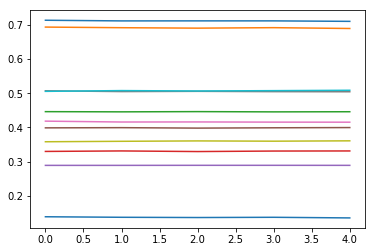

In [200]:
plt.plot([k for k in best_model.predict(np.reshape(data[-5:], (5, 1, data.shape[1])))])
plt.show()